In [1]:
# Import Library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, classification_report
import statsmodels.api as sm
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# data train url
# i saved the data set on github
url_train = 'https://raw.githubusercontent.com/indraone001/ML_Dataset/main/salju_train.csv'

# read csv file using pandas
data = pd.read_csv(url_train)
data.head()

,id,Tanggal,KodeLokasi,SuhuMin,SuhuMax,Hujan,Penguapan,SinarMatahari,ArahAnginTerkencang,KecepatanAnginTerkencang,ArahAngin9am,ArahAngin3pm,KecepatanAngin9am,KecepatanAngin3pm,Kelembaban9am,Kelembaban3pm,Tekanan9am,Tekanan3pm,Awan9am,Awan3pm,Suhu9am,Suhu3pm,BersaljuHariIni,BersaljuBesok
0,1,01/06/2014,C4,10.400,15.500,4.800,nan,nan,WSW,24.000,NaN,WSW,0.000,13.000,78.000,76.000,1020.100,1018.500,nan,nan,13.100,15.000,Ya,Tidak
1,2,15/07/2014,C10,9.000,17.000,8.000,2.600,7.400,NaN,nan,SW,WNW,13.000,20.000,80.000,61.000,1015.200,1014.600,7.000,5.000,11.900,15.500,Ya,Ya
2,3,16/02/2011,C46,18.200,32.000,0.000,nan,nan,ESE,44.000,SE,SE,15.000,26.000,62.000,42.000,nan,nan,nan,nan,23.800,29.600,Tidak,Tidak
3,4,08/08/2012,C36,7.300,24.500,0.000,8.400,10.400,SSW,54.000,N,SW,13.000,19.000,25.000,17.000,1019.200,1016.900,1.000,7.000,15.300,23.200,Tidak,Tidak
4,5,29/10/2016,C7,5.900,20.300,0.000,3.600,12.600,N,37.000,NNW,ESE,22.000,19.000,55.000,48.000,1019.700,1014.700,2.000,6.000,12.400,18.100,Tidak,Tidak


In [3]:
# drop unused variable
data.drop(['KodeLokasi','Tanggal'], axis=1, inplace=True)

In [4]:
# categorical Data
# Fill in mssing value
data[['ArahAnginTerkencang','ArahAngin9am','ArahAngin3pm','BersaljuHariIni']] = \
data[['ArahAnginTerkencang','ArahAngin9am','ArahAngin3pm','BersaljuHariIni']].fillna('unknown')

# change data types
data[['ArahAnginTerkencang','ArahAngin9am','ArahAngin3pm','BersaljuHariIni','BersaljuBesok']] = \
data[['ArahAnginTerkencang','ArahAngin9am','ArahAngin3pm','BersaljuHariIni','BersaljuBesok']].astype('category')

In [5]:
# Numerical Data
numerical = data.select_dtypes(include='number')
numerical.describe()
numerical.isna().sum()/len(data)
data.drop(['Penguapan','SinarMatahari','Awan3pm'], axis=1, inplace=True)

In [6]:
# input missing value
med_ = data[['SuhuMin','SuhuMax','Hujan','KecepatanAnginTerkencang','KecepatanAngin9am','KecepatanAngin3pm','Kelembaban9am','Tekanan9am',\
             'Tekanan3pm','Suhu9am','Suhu3pm']]
men_ = data[['Kelembaban3pm','Awan9am']]

for col in med_:
    col_median=data[col].median()
    data[col].fillna(col_median, inplace=True)
    
for col_ in men_:
    col_mean=data[col_].mean()
    data[col_].fillna(col_mean,inplace=True)

In [7]:
# remove outliers
Q1 = numerical.quantile(0.25)
Q3 = numerical.quantile(0.75)
IQR = Q3 - Q1

In [8]:
# count outliers
data_wo_outliers = data[~((numerical < (Q1 - 1.5 * IQR)) |(numerical > (Q3 + 1.5 * IQR))).any(axis=1)]
data_wo_outliers.shape

(84059, 19)

Bersalju 22 %
Tidak Bersalju 76 %


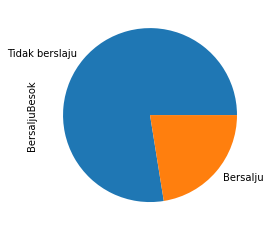

In [36]:
# Eplanatory Data Analysis
# Check prortion class target
data['BersaljuBesok'].value_counts().plot(kind = 'pie', labels = [ 'Tidak berslaju','Bersalju'])
print('Bersalju', round(data['BersaljuBesok'].value_counts()['Ya']/len(data) * 100), '%')
print('Tidak Bersalju', round(data['BersaljuBesok'].value_counts()['Tidak']/len(data) * 100), '%')

In [10]:
# Logistic Regression

cat_columns = data.select_dtypes(['category']).columns
data_new = pd.get_dummies(data, columns = cat_columns, drop_first = True)
data_new.head(2)

,id,SuhuMin,SuhuMax,Hujan,KecepatanAnginTerkencang,KecepatanAngin9am,KecepatanAngin3pm,Kelembaban9am,Kelembaban3pm,Tekanan9am,Tekanan3pm,Awan9am,Suhu9am,Suhu3pm,ArahAnginTerkencang_ENE,ArahAnginTerkencang_ESE,ArahAnginTerkencang_N,ArahAnginTerkencang_NE,ArahAnginTerkencang_NNE,ArahAnginTerkencang_NNW,ArahAnginTerkencang_NW,ArahAnginTerkencang_S,ArahAnginTerkencang_SE,ArahAnginTerkencang_SSE,ArahAnginTerkencang_SSW,ArahAnginTerkencang_SW,ArahAnginTerkencang_W,ArahAnginTerkencang_WNW,ArahAnginTerkencang_WSW,ArahAnginTerkencang_unknown,ArahAngin9am_ENE,ArahAngin9am_ESE,ArahAngin9am_N,ArahAngin9am_NE,ArahAngin9am_NNE,ArahAngin9am_NNW,ArahAngin9am_NW,ArahAngin9am_S,ArahAngin9am_SE,ArahAngin9am_SSE,ArahAngin9am_SSW,ArahAngin9am_SW,ArahAngin9am_W,ArahAngin9am_WNW,ArahAngin9am_WSW,ArahAngin9am_unknown,ArahAngin3pm_ENE,ArahAngin3pm_ESE,ArahAngin3pm_N,ArahAngin3pm_NE,ArahAngin3pm_NNE,ArahAngin3pm_NNW,ArahAngin3pm_NW,ArahAngin3pm_S,ArahAngin3pm_SE,ArahAngin3pm_SSE,ArahAngin3pm_SSW,ArahAngin3pm_SW,ArahAngin3pm_W,ArahAngin3pm_WNW,ArahAngin3pm_WSW,ArahAngin3pm_unknown,BersaljuHariIni_Ya,BersaljuHariIni_unknown,BersaljuBesok_Ya
0,1,10.400,15.500,4.800,24.000,0.000,13.000,78.000,76.000,1020.100,1018.500,4.451,13.100,15.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,2,9.000,17.000,8.000,39.000,13.000,20.000,80.000,61.000,1015.200,1014.600,7.000,11.900,15.500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1


In [11]:
#separate predictor and target
X = data_new.drop('BersaljuBesok_Ya', axis=1)
y = data_new.BersaljuBesok_Ya.values

#setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train:",X_train.shape)
print("X_test:",X_test.shape)
print("y_train:",y_train.shape)
print("y_test:",y_test.shape)

X_train: (87276, 64)
X_test: (21819, 64)
y_train: (87276,)
y_test: (21819,)


In [12]:
lr = LogisticRegression(multi_class='ovr',solver='liblinear').fit(X_train, y_train)
lr_pred = lr.predict(X_test)

In [13]:
logit_acc1 = accuracy_score(y_test, lr_pred)
print('Accuracy:', logit_acc1)

Accuracy: 0.83702277831248


In [14]:
# Multicolinearity
# gather features
col_dat = data_wo_outliers.drop(['BersaljuBesok'],axis=1)
features = "+".join(col_dat.columns)

from sklearn import metrics
from patsy import dmatrices
y, X = dmatrices('BersaljuBesok ~' + features, data_wo_outliers, return_type='dataframe')

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

vif[vif["VIF Factor"]>10]

,VIF Factor,features
0,48012.588,Intercept
53,22.540,SuhuMax
60,20.843,Tekanan9am
61,20.880,Tekanan3pm
63,18.050,Suhu9am
64,22.221,Suhu3pm


<Figure size 360x360 with 0 Axes>

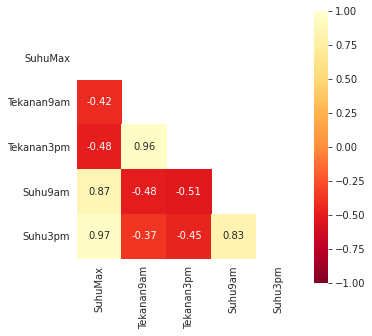

In [15]:
cor_death = data_wo_outliers[['SuhuMax','Tekanan9am','Tekanan3pm','Suhu9am','Suhu3pm']]
pd.set_option('precision', 3)
correlation=cor_death.corr(method='pearson')
# heatmap of the correlation 
plt.figure(figsize=(5,5))
mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(5, 5))
    ax = sns.heatmap(correlation, mask=mask, square=True,annot=True,vmin=-1,vmax=1,cmap="YlOrRd_r")

In [16]:
# Feature Engineering

X_new = data_new.drop(['Kelembaban9am','Suhu9am','Suhu3pm','ArahAnginTerkencang_ENE','ArahAnginTerkencang_N','ArahAnginTerkencang_NNW','ArahAnginTerkencang_NW',\
                      'ArahAnginTerkencang_S','ArahAnginTerkencang_SSW','ArahAnginTerkencang_W','ArahAnginTerkencang_WNW','ArahAnginTerkencang_WSW','ArahAnginTerkencang_unknown',\
                      'ArahAngin9am_NNW','ArahAngin9am_SSW','ArahAngin9am_SW','ArahAngin9am_W','ArahAngin9am_WSW','ArahAngin9am_unknown',\
                      'ArahAngin3pm_ENE','ArahAngin3pm_ESE','ArahAngin3pm_SE','ArahAngin3pm_SSE','ArahAngin3pm_SW','BersaljuBesok_Ya'],axis=1)
y_new = data_new.BersaljuBesok_Ya.values


In [17]:
# Logistic Model 2 without unsignificant variables

#setting up testing and training sets
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

lr_new = LogisticRegression(multi_class='ovr',solver='liblinear').fit(X_train_new, y_train_new)
lr_pred_new= lr_new.predict(X_test_new)

logit_acc2 = accuracy_score(y_test_new, lr_pred_new)
print('Accuracy:', logit_acc2)

Accuracy: 0.8383977267519135


In [18]:
# Logistic Model 3 without outliers and unsignificant variables

cat_columns_n = data_wo_outliers.select_dtypes(['category']).columns
data_no_out = pd.get_dummies(data_wo_outliers, columns = cat_columns_n, drop_first = True)

X_wo_out = data_no_out.drop(['Kelembaban9am','Suhu9am','Suhu3pm','ArahAnginTerkencang_ENE','ArahAnginTerkencang_N','ArahAnginTerkencang_NNW','ArahAnginTerkencang_NW',\
                      'ArahAnginTerkencang_S','ArahAnginTerkencang_SSW','ArahAnginTerkencang_W','ArahAnginTerkencang_WNW','ArahAnginTerkencang_WSW','ArahAnginTerkencang_unknown',\
                      'ArahAngin9am_NNW','ArahAngin9am_SSW','ArahAngin9am_SW','ArahAngin9am_W','ArahAngin9am_WSW','ArahAngin9am_unknown',\
                      'ArahAngin3pm_ENE','ArahAngin3pm_ESE','ArahAngin3pm_SE','ArahAngin3pm_SSE','ArahAngin3pm_SW','BersaljuBesok_Ya'],axis=1)
y_wo_out = data_no_out.BersaljuBesok_Ya.values

X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_wo_out, y_wo_out, test_size=0.2, random_state=42)

lr_wo = LogisticRegression(multi_class='ovr',solver='liblinear').fit(X_train_w, y_train_w)
lr_pred_wo= lr_wo.predict(X_test_w)

logit_acc3 = accuracy_score(y_test_w, lr_pred_wo)
print('Accuracy:', logit_acc3)

Accuracy: 0.8642041399000714


In [19]:
# Feature Engineering
# Remove Multicolinearity

#1. Mean between Suhu9am and Suhu3pm
data_wo_outliers['Suhu'] = (data_wo_outliers.Suhu9am + data_wo_outliers.Suhu3pm)/2
data_wo_outliers.drop(['Suhu9am','Suhu3pm'], axis=1, inplace=True)

#2. Mean between Tekanan9am and Tekanan3pm
data_wo_outliers['Tekanan'] = (data_wo_outliers.Tekanan9am + data_wo_outliers.Tekanan3pm)/2
data_wo_outliers.drop(['Tekanan9am','Tekanan3pm'], axis=1, inplace=True)

#3. Drop Max Suhu
data_wo_outliers.drop(['SuhuMax'], axis=1, inplace=True)

In [20]:
# Logistic Model 4 without outliers and unsignificant variables, and multicolinearity

cat_columns_nw = data_wo_outliers.select_dtypes(['category']).columns
data_no_out2 = pd.get_dummies(data_wo_outliers, columns = cat_columns_nw, drop_first = True)

X_wo_out2 = data_no_out2.drop(['Kelembaban9am','Tekanan','ArahAnginTerkencang_ENE','ArahAnginTerkencang_N','ArahAnginTerkencang_NNW','ArahAnginTerkencang_NW',\
                      'ArahAnginTerkencang_S','ArahAnginTerkencang_SSW','ArahAnginTerkencang_W','ArahAnginTerkencang_WNW','ArahAnginTerkencang_WSW','ArahAnginTerkencang_unknown',\
                      'ArahAngin9am_NNW','ArahAngin9am_SSW','ArahAngin9am_SW','ArahAngin9am_W','ArahAngin9am_WSW','ArahAngin9am_unknown',\
                      'ArahAngin3pm_ENE','ArahAngin3pm_ESE','ArahAngin3pm_SE','ArahAngin3pm_SSE','ArahAngin3pm_SW','BersaljuBesok_Ya'],axis=1)
y_wo_out2 = data_no_out2.BersaljuBesok_Ya.values

X_train_w2, X_test_w2, y_train_w2, y_test_w2 = train_test_split(X_wo_out2, y_wo_out2, test_size=0.2, random_state=42)

lr_wo2 = LogisticRegression(multi_class='ovr',solver='liblinear').fit(X_train_w2, y_train_w2)
lr_pred_wo2= lr_wo2.predict(X_test_w2)

logit_acc4 = accuracy_score(y_test_w2, lr_pred_wo2)
print('Accuracy:', logit_acc4)

Accuracy: 0.8505829169640733


In [21]:
# Model comparison

comparison_logit = {'Model': ['Model Logit 1 - using original data', 'Model Logit 2 - without unsignificant variables', \
                              'Model Logit 3 - without outliers and unsignificant variables','Model Logit 4 - without outliers, unsignificant variables, and multicolinearity'],\
              'Accuracy': [round(logit_acc1, 3), round(logit_acc2, 3), round(logit_acc3, 3),round(logit_acc4, 3)]
              }
pd.DataFrame.from_dict(comparison_logit)

,Model,Accuracy
0,Model Logit 1 - using original data,0.837
1,Model Logit 2 - without unsignificant variables,0.838
2,Model Logit 3 - without outliers and unsignifi...,0.864
3,"Model Logit 4 - without outliers, unsignifican...",0.851


In [22]:
# Modelling
# K-NN (K-Nearest Neighbors)

# exclude categorical variable from data
X_wo_out3 = data_wo_outliers.drop(['ArahAnginTerkencang','ArahAngin9am','ArahAngin3pm','BersaljuHariIni','BersaljuBesok'],axis=1)
X_train_w3, X_test_w3, y_train_w3, y_test_w3 = train_test_split(X_wo_out3, y_wo_out2, test_size=0.2, random_state=42)


In [23]:
# Scaling data values
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_wo_out3)
X_wo_out3 = pd.DataFrame(scaler.transform(X_wo_out3), index=X_wo_out3.index, columns=X_wo_out3.columns)

In [24]:
# Create Model
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 3)
classifier.fit(X_train_w3,y_train_w3)

knn_pred = classifier.predict(X_test_w3)

score = accuracy_score(y_test_w3,knn_pred)
print('Accuracy :',score)

Accuracy : 0.8304187485129669


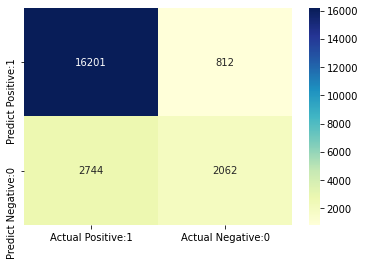

In [25]:
# Matrik evaluation Logistic regresstion

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, lr_pred)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

In [26]:
# print precision score

precision = TP / float(TP + FP)
precision

0.9522717921589373

In [27]:
# recall

recall = TP / float(TP + FN)
recall

0.8551596727368699

In [28]:
#calculate F1 logistic
f1_logi = 2*precision*recall/(precision+recall)
print(f1_logi)

0.901106846876912


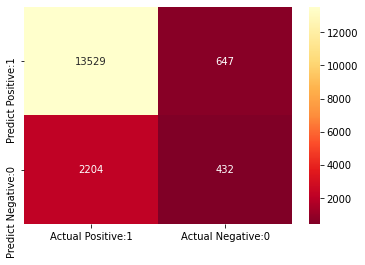

In [29]:
# Matrik evaluation KNN

cm_knn = confusion_matrix(y_test_w3, knn_pred)
cm_matrix_knn = pd.DataFrame(data=cm_knn, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix_knn, annot=True, fmt='d', cmap='YlOrRd_r')

TP_KNN = cm_knn[0,0]
TN_KNN = cm_knn[1,1]
FP_KNN = cm_knn[0,1]
FN_KNN = cm_knn[1,0]

In [30]:
# precision

precision_knn = TP_KNN / float(TP_KNN + FP_KNN)
precision_knn

0.9543594808126411

In [31]:
# recall

recall_knn = TP_KNN / float(TP_KNN + FN_KNN)
recall_knn

0.8599122862772517

In [32]:
#calculate F1 knn
f1_knn = 2*precision_knn*recall_knn/(precision_knn+recall_knn)
print(f1_knn)

0.9046775218161758


In [33]:
# Model Comparison

comparison = {'Model': ['Logistic Regression', 'K-Nearest Neighbor'],\
              'Accuracy': [round(logit_acc3, 3), round(score, 3)],\
              'Precision':[round(precision, 3), round(precision_knn, 3)],\
              'Recall':[round(recall, 3), round(recall_knn, 3)],
              'F1':[round(f1_logi, 3), round(f1_knn, 3)]}
pd.DataFrame.from_dict(comparison)

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.864,0.952,0.855,0.901
1,K-Nearest Neighbor,0.830,0.954,0.860,0.905
